In [1]:
#This notebook is an example of FGSM on MNIST dataset (fast gradient sign attack)
#WB and BB attacks involving either Misclassification or source/target misclassification

#FGSM is an algo that modifies the ip data based on gradients
#It calculates the gradient of the loss func which is to be minimized, and from that grad, it modifies the input data in such a way to max the loss

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#epsilon is a measure of the pertubation applied on the ip image
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = '/content/drive/My Drive/lenet_mnist_model.pth'
use_cuda = True

In [36]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [37]:
cuda = torch.cuda.is_available()
device = ('cuda' if cuda else 'cpu')
device

'cuda'

In [38]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, 5)
    self.conv2 = nn.Conv2d(10, 20, 5)
    self.conv_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.max_pool2d(x, 2)
    x = F.relu(x)
    x = self.conv2(x) 
    x = self.conv_drop(x)
    x = F.max_pool2d(x, 2)
    x = F.relu(x)
    x = x.view(-1, 320)
    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim = 1) 

In [39]:
model = Net().to(device)
#load the weights of pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model.eval() # Set the model in evaluation mode. In this case this is for the Dropout layers

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [40]:
def fgsm_attack(image, epsilon, data_grad):
  #data_grad is the grad of the loss function wrt ip image
  #perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y)

  sign_data_grad = data_grad.sign()
  perturbed_image = image + epsilon * sign_data_grad
  #to maintain the original data range
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  return perturbed_image

In [41]:
def test(model, device, test_loader, epsilon):

  correct = 0
  #adversarial examples list to plot or display later
  adv_examples = []

  for data, target in test_loader:

    data, target = data.to(device), target.to(device)
    data.requires_grad = True #this is needed for the attack
    output = model(data)
    initial_pred = torch.max(output, 1)[1]

    #if the pred is wrong, do not bother to attack
    if initial_pred.item() != target.item():
      continue

    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    output = model(perturbed_data)

    #Check for success/fail after attempt to classify attacked image
    final_pred = torch.max(output, 1)[1]

    if final_pred.item() == target.item():
      correct += 1
      if (epsilon == 0) and len(adv_examples) < 5: # Special case for saving 0 epsilon examples
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((initial_pred.item(), final_pred.item(), adv_ex))

    else: # Save some adv examples for visualization later
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()  #remove the batch_dims
        adv_examples.append((initial_pred.item(), final_pred.item(), adv_ex))      

  final_accuracy = correct / float(len(test_loader)) 
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_accuracy)) 

  return final_accuracy, adv_examples      
              
#first run a normal cycle, check preds, and if it is correct, summon the attack and check the prediction, if it is different, save the example in a list for later in array form, and is correct, save the case where epsilon = 0 also, as this is not a failed case but just a reproduction 

In [43]:
accuracies = []
examples = []

for eps in epsilons:
  acc, ex = test(model, device, test_loader, eps)
  accuracies.append(acc)
  examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


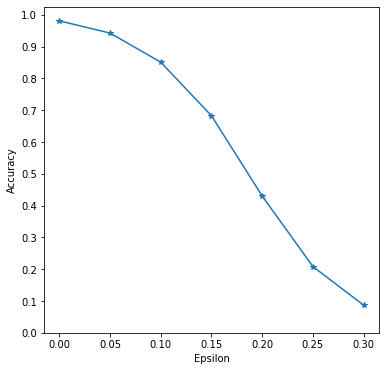

In [44]:
plt.figure(figsize = (6, 6))
plt.plot(epsilons, accuracies, "*-")
plt.xticks(np.arange(0, 0.35, step = 0.05))
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

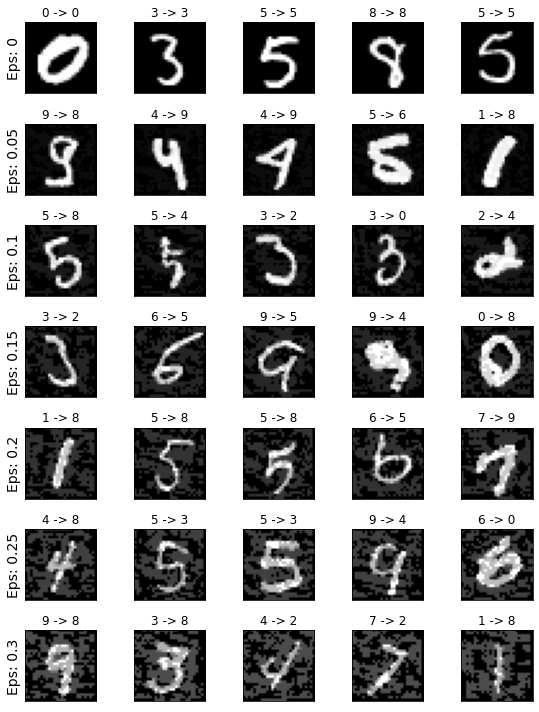

In [52]:
# Plot several examples of adversarial samples at each epsilon
idx = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        idx += 1
        plt.subplot(len(epsilons),len(examples[0]),idx)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()